# 卒業研究9：畳み込みニューラルネットワークでの学習

### 坂西和也

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# データの読み込み
import os

# カレントディレクトリを取得
data_path = os.getcwd()

In [87]:
data_path

'/content'

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam

import numpy as np
import tensorflow as tf
import os
import random

# 乱数のシードを設定
seed_value = 111
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# cuDNNの非決定的なアルゴリズムを使用しない設定
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# データの読み込み
df = pd.read_csv('/content/drive/MyDrive/卒研/dataset01_.csv')
# 1列目を除外
df = df.iloc[:, 1:]

# 入力データとラベルを作成
X = df.T.values  # 転置を取ることで、次元が128、サンプル数が50になる
X = X[:, :, None]  # 1D-CNNに適用するために、3次元の形状に変形
number = 25
random_number = 25
y = [1]*number + [0]*random_number
y = np.array(y)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_view = np.copy(X_test)

# 訓練データを用いてStandardScalerを学習
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_train = X_train_reshaped.reshape(X_train.shape)

# テストデータにも同じ正規化を適用
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_reshaped = scaler.transform(X_test_reshaped)  # 注意: fit_transformではなく、transformを使う
X_test = X_test_reshaped.reshape(X_test.shape)

# 1D-CNNモデルの構築
model = Sequential()
# L2正則化を畳み込み層と全結合層に追加
reg_strength = 0.1  # 正則化の強度を設定（この値は調整が必要）
model.add(Conv1D(filters=32, kernel_size=5, input_shape=(128, 1), kernel_regularizer=l2(reg_strength)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
optimizer = Adam(learning_rate=0.001)  # Adamのインスタンスを作成。必要に応じて学習率を調整
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# モデルの訓練
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# テストデータでの性能評価
_, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Epoch 1/50
3/3 [==============================] - 2s 167ms/step - loss: 12.9519 - accuracy: 0.5143 - val_loss: 11.6832 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 43ms/step - loss: 11.1573 - accuracy: 0.6857 - val_loss: 10.0358 - val_accuracy: 0.6667
Epoch 3/50
3/3 [==============================] - 0s 31ms/step - loss: 9.6102 - accuracy: 0.9143 - val_loss: 8.6144 - val_accuracy: 0.7333
Epoch 4/50
3/3 [==============================] - 0s 29ms/step - loss: 8.2057 - accuracy: 1.0000 - val_loss: 7.4669 - val_accuracy: 0.4667
Epoch 5/50
3/3 [==============================] - 0s 32ms/step - loss: 7.0072 - accuracy: 0.8286 - val_loss: 6.4202 - val_accuracy: 0.4667
Epoch 6/50
3/3 [==============================] - 0s 34ms/step - loss: 5.9273 - accuracy: 0.9143 - val_loss: 5.3471 - val_accuracy: 0.8667
Epoch 7/50
3/3 [==============================] - 0s 37ms/step - loss: 5.0207 - accuracy: 0.9714 - val_loss: 4.5022 - val_accuracy: 0.8000
Epoch 8/50
3/3 [======

1/1 [==============================] - 0s 72ms/step


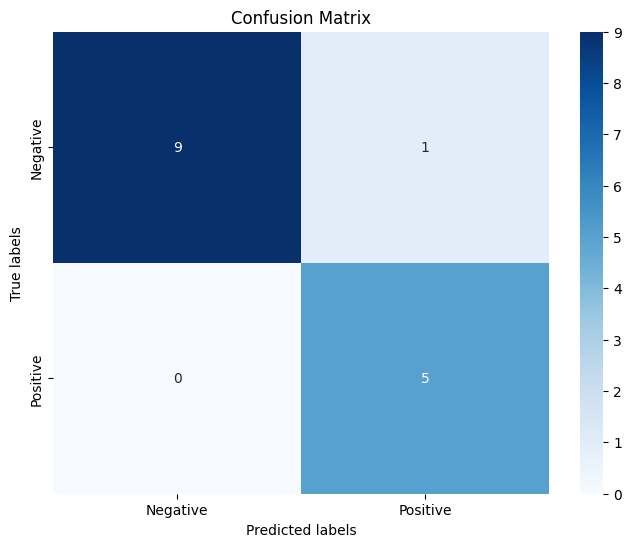

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# テストデータでの予測
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()  # 0または1に丸める

# 混同行列を計算
cm = confusion_matrix(y_test, y_pred)

# 混同行列をヒートマップとして表示
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [101]:
# データの読み込み
dataset = pd.read_csv('/content/drive/MyDrive/卒研/dataset01_.csv')
# 入力データとして、各カラムを1つのサンプルとする
X = dataset.drop('Velocity (mm/s)', axis=1)
y = y
# データセットをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.3, random_state=111)

In [102]:
# X_testの列名と予測結果を表示
for column_name, prediction in zip(X_test.index, y_pred):
    print(f"Sample: {column_name}, Prediction: {prediction}")

Sample: random_noise_8, Prediction: 0.0
Sample: random_noise_5, Prediction: 1.0
Sample: random_noise_6, Prediction: 0.0
Sample: random_noise_9, Prediction: 0.0
Sample: noisy_16, Prediction: 1.0
Sample: random_noise_4, Prediction: 0.0
Sample: noisy_0, Prediction: 1.0
Sample: noisy_17, Prediction: 1.0
Sample: random_noise_21, Prediction: 0.0
Sample: random_noise_10, Prediction: 0.0
Sample: noisy_15, Prediction: 1.0
Sample: random_noise_11, Prediction: 0.0
Sample: noisy_9, Prediction: 1.0
Sample: random_noise_13, Prediction: 0.0
Sample: random_noise_23, Prediction: 0.0


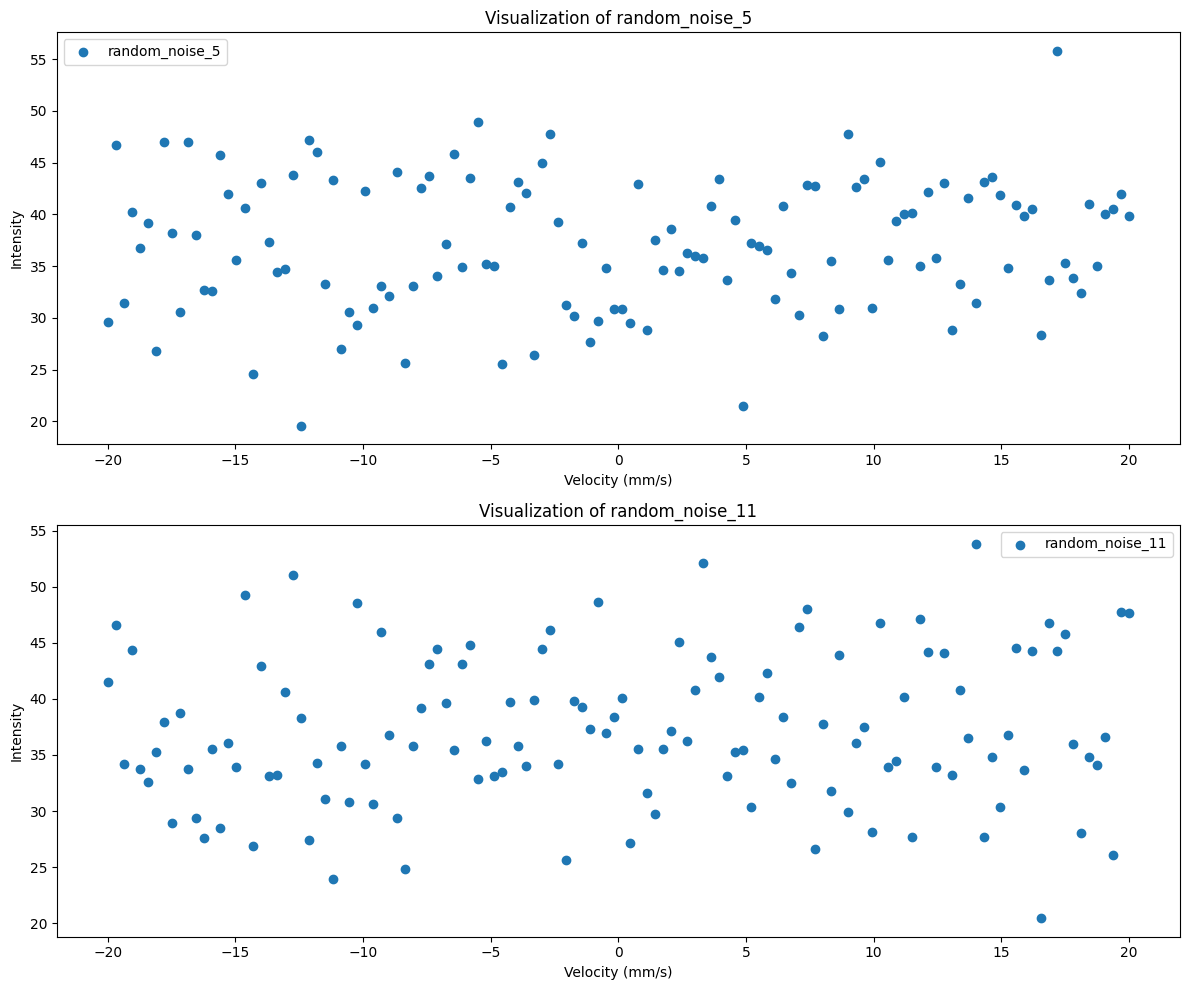

In [103]:
import matplotlib.pyplot as plt

# 指定されたカラムのデータをプロット
columns_to_visualize = ['random_noise_5' ,  'random_noise_11']

# 2x2のグリッドでプロット
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 各カラムのデータをプロット
for ax, column in zip(axes.ravel(), columns_to_visualize):
    ax.scatter(dataset['Velocity (mm/s)'], dataset[column], label=column)
    ax.set_xlabel('Velocity (mm/s)')
    ax.set_ylabel('Intensity')
    ax.legend()
    ax.set_title(f'Visualization of {column}')

plt.tight_layout()
plt.show()